In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
from activ.analytics import heatmap
from activ.clustering import UmapClusteringResults
from os.path import dirname, join
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize
from scipy.optimize import curve_fit

In [2]:
filename = '/Users/ahyeon/Desktop/activ/results/features_dropped/oc_features_dropped/single_dim/dim_2_oc_dropped_result_0.h5'
f = h5py.File(filename, 'r')

In [10]:
predictions = np.squeeze(f['score'][:], axis=1)
norm_predictions = np.squeeze(f['norm_score'][:], axis=1)
labels = np.squeeze(f['clusters'][:], axis=1)
umap_dims = f['umap_dimensions'][:]
cluster_sizes = f['cluster_sizes'][:]

In [167]:
def conf_alliter(size, predicted, actual):
    confalliter = []
    for j in range(50):
        conf = np.zeros((size,size))
        labs = list(map(int, actual[j][size-2]))
        preds = list(map(int, predicted[j][size-2]))
        for l, p in zip(labs, preds):
            conf[l,p] += 1
        confalliter.append(conf)
    return confalliter

In [168]:
def accuracy(mat):
    return mat.trace()/mat.sum()

In [169]:
def ind_statistics(matrix):
    mat = np.matrix(matrix)
    allvals=[]
    tps = []
    tns = []
    fps = []
    fns = []
    for i in range(mat.shape[0]):
        tp = mat[i,i]
        tn = mat.sum() - mat[i,:].sum() - mat[:,i].sum() + mat[i,i]
        fp = mat[:,i].sum() - mat[i,i]
        fn = mat[i,:].sum() - mat[i,i]
        tps.append(tp)
        tns.append(tn)
        fps.append(fp)
        fns.append(fn)
    allvals.append(tps)
    allvals.append(tns)
    allvals.append(fps)
    allvals.append(fns)
    return allvals

In [170]:
def find_avg_sens(array):
    allsens = []
    for i in range(len(array[0])):
        vals = []
        for elem in array:
            vals.append(elem[i])
        tp = vals[0]
        tn = vals[1]
        fp = vals[2]
        fn = vals[3]
        sens = sensitivity(tp, fn)
        allsens.append(sens)
    allsens_mean = np.mean(allsens)
    return(allsens_mean)

In [171]:
def find_avg_spec(array):
    allspec = []
    for i in range(len(array[0])):
        vals = []
        for elem in array:
            vals.append(elem[i])
        tp = vals[0]
        tn = vals[1]
        fp = vals[2]
        fn = vals[3]
        spec = specificity(tn, fp)
        allspec.append(spec)
    allspec_mean = np.mean(allspec)
    return(allspec_mean)

In [172]:
def find_avg_fscore(array):
    allf = []
    for i in range(len(array[0])):
        vals = []
        for elem in array:
            vals.append(elem[i])
        tp = vals[0]
        tn = vals[1]
        fp = vals[2]
        fn = vals[3]
        f = fscore(tp, fp, fn)
        allf.append(f)
    allf_mean = np.mean(allf)
    return(allf_mean)

In [134]:
def func(x, a, b, c):
    return (a * np.exp(-b * x)) + c

In [174]:
acc_arr = np.zeros((len(cluster_sizes), 50))
for ii,c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    acc = [accuracy(i) for i in all50mat]
    norm_acc = [accuracy(i) for i in norm_all50mat]
    foc = [x/y for x, y in zip(acc, norm_acc)]
    acc_arr[ii,:] = foc

In [201]:
# avg sensitivity

sens_arr = np.zeros((len(cluster_sizes), 50))
for ii, c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    sens_50 = []
    norm_sens_50 = []
    for i in range(50):
        x = ind_statistics(all50mat[i])
        y = ind_statistics(norm_all50mat[i])
        sens = find_avg_sens(x)
        norm_sens = find_avg_sens(y)
        sens_50.append(sens)
        norm_sens_50.append(norm_sens)
    foc = [j/k for j,k in zip(sens_50, norm_sens_50)]
    sens_arr[ii,:] = foc

In [189]:
f_arr = np.zeros((len(cluster_sizes), 50))
for ii, c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    f_50 = []
    norm_f_50 = []
    for i in range(50):
        x = ind_statistics(all50mat[i])
        y = ind_statistics(norm_all50mat[i])
        f = find_avg_fscore(x)
        norm_f = find_avg_fscore(y)
        f_50.append(f)
        norm_f_50.append(norm_f)
    foc = [j/k for j,k in zip(f_50, norm_f_50)]
    f_arr[ii,:] = foc

In [192]:
f_arr.shape

(49, 50)

In [213]:

spec_arr = np.zeros((len(cluster_sizes), 50, 3))
for ii, c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    spec_50 = []
    norm_spec_50 = []
    for i in range(50):
        x = ind_statistics(all50mat[i])
        y = ind_statistics(norm_all50mat[i])
        spec = find_avg_spec(x)
        norm_spec = find_avg_spec(y)
        spec_50.append(spec)
        norm_spec_50.append(norm_spec)
    foc = [j/k for j,k in zip(spec_50, norm_spec_50)]
    spec_arr[ii,:,0] = foc
    spec_arr[ii,:,1] = spec_50
    spec_arr[ii,:,2] = norm_spec_50

In [235]:
def plot_optimal_k(data, name):
    yvar = np.var(data, axis=1)
    ydata = np.mean(data, axis=1)
    popt, pcov = curve_fit(func, cluster_sizes, ydata, p0 = [1000,1,3])
    yval = func(cluster_sizes, *popt) 
    y = ydata
    plt.figure(figsize=(10,10))
    plt.plot(cluster_sizes, ydata, label='data', color='black')
    plt.plot(cluster_sizes, yval, '--',label='fit', color='red')
    plt.plot(cluster_sizes, [popt[2]]*len(cluster_sizes), '--', color='grey', label='asymptote')

    shift = 1.96*np.sqrt(yvar)
    grey_shift = 1.96*np.sqrt(pcov[2][2])
    optimal_k = np.where([popt[2]]*len(cluster_sizes)-grey_shift-(y+shift) <0)[0][0]+2
    plt.axvline(optimal_k, label='optimal k')
    plt.fill_between(cluster_sizes, y+shift, y-shift, alpha = 0.2, color='pink')
    plt.fill_between(cluster_sizes, [popt[2]]*len(cluster_sizes)+grey_shift, [popt[2]]*len(cluster_sizes)-grey_shift, alpha = 0.2, color='grey')

    plt.xlabel('Cluster Number', fontsize=16)
    plt.ylabel('Fold over Chance', fontsize=16)
    plt.title('{} vs Cluster Number\nk={}'.format(name, optimal_k), fontsize=20)
    plt.legend()

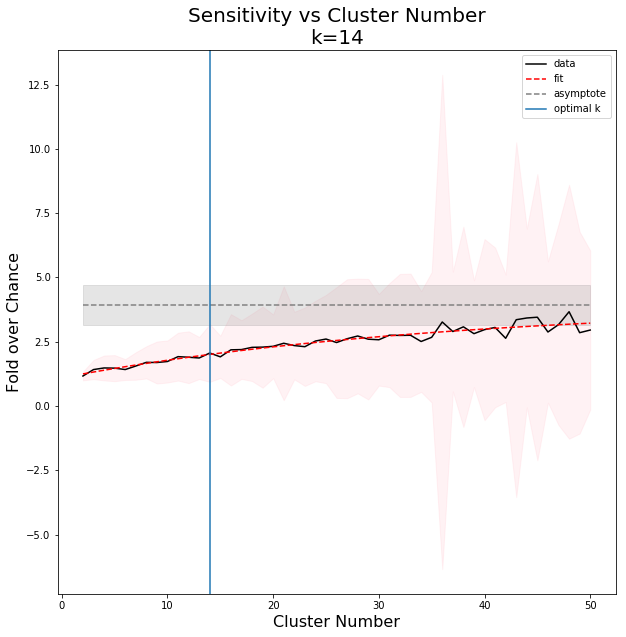

In [236]:
plot_optimal_k(sens_arr, 'Sensitivity')

In [255]:
def jacobian(x,a,b,c):
    d1 = np.exp(-b*x)
    d2 = -x * a * np.exp(-b*x)
    d3 = 1
    return ([d1, d2, d3])

0.609923499318045


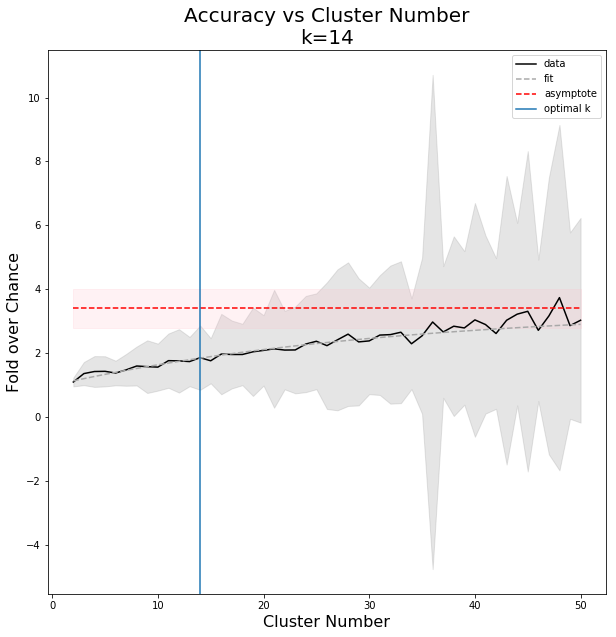

In [259]:
data = acc_arr
yvar = np.var(data, axis=1)
shift = 1.96*np.sqrt(yvar)
ydata = np.mean(data, axis=1)
popt, pcov = curve_fit(func, cluster_sizes, ydata, sigma=np.sqrt(yvar))

yval = func(cluster_sizes, *popt) 
y = ydata
plt.figure(figsize=(10,10))
plt.plot(cluster_sizes, ydata, label='data', color='black')
plt.plot(cluster_sizes, yval, '--',label='fit', color='darkgrey')
plt.plot(cluster_sizes, [popt[2]]*len(cluster_sizes), '--', color='red', label='asymptote')


grey_shift = 1.96*np.sqrt(pcov[2][2])
print(grey_shift)
optimal_k = np.where([popt[2]]*len(cluster_sizes)-grey_shift-(ydata+shift) <0)[0][0]+2
plt.axvline(optimal_k, label='optimal k')
plt.fill_between(cluster_sizes, ydata+shift, ydata-shift, alpha = 0.2, color='grey')
plt.fill_between(cluster_sizes, [popt[2]]*len(cluster_sizes)+grey_shift, [popt[2]]*len(cluster_sizes)-grey_shift, alpha = 0.2, color='pink')

plt.xlabel('Cluster Number', fontsize=16)
plt.ylabel('Fold over Chance', fontsize=16)
plt.title('Accuracy vs Cluster Number\nk=14', fontsize=20)
plt.legend()
plt.savefig('/Users/ahyeon/Desktop/activ misc/dim2_optimalk_acc.pdf')

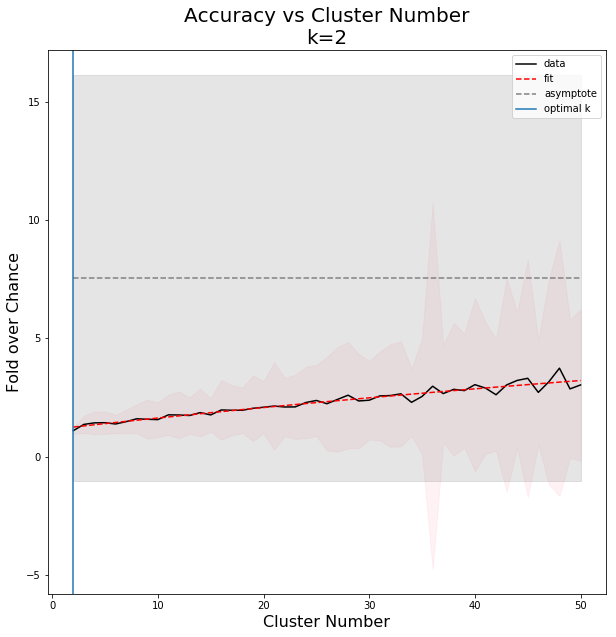

In [237]:
plot_optimal_k(acc_arr, 'Accuracy')

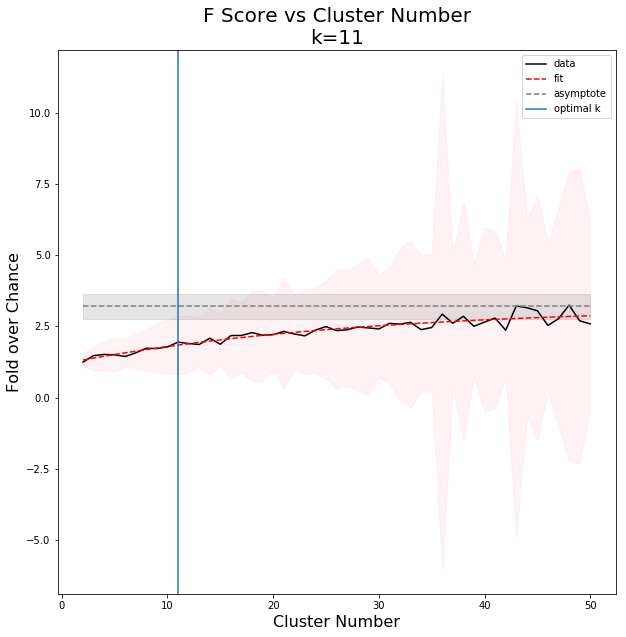

In [211]:
plot_optimal_k(f_arr, 'F Score')

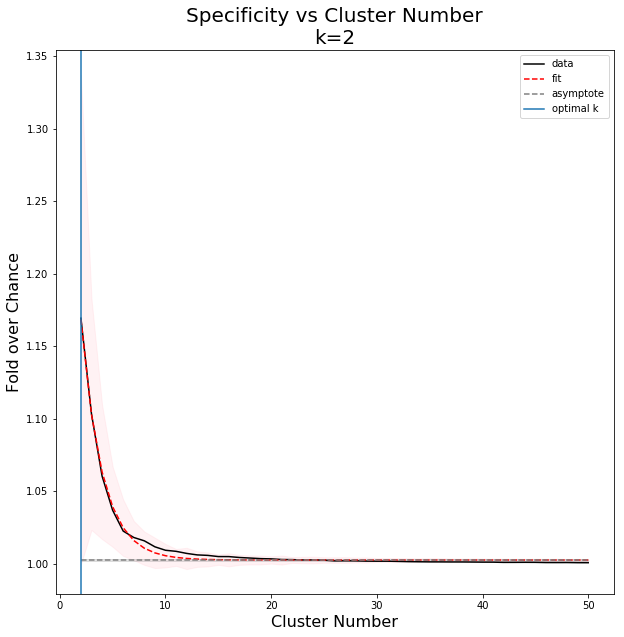

In [215]:
plot_optimal_k(spec_arr[:,:,0], 'Specificity')